# **Final Exam for Deep Network Development course. First part (mandatory)**

This notebook contains the task to be solved in order to pass the exam. 
This is the first part of the exam, which is compolsury in order to get a grade. It contains a task similar to what you have worked on during the semester, which consists on implementing a network architecture and a function.

Please note that, to **PASS** the Deep Network Development course you must **SUBMIT A SUCCESSFUL SOLUTION FOR THE FIRST PART**. If you **FAIL** the first part, you have the right to do the exam **ONE MORE TIME**. If you **FAIL AGAIN**, then unfortunately, you have failed the course. If you **PASS** the first part, then you get the weighted average of your quizzes and assignments as your final grade.

## Your information
Please fill the next cell with your information

**Full Name**:

**Neptun code:**

**Date:** 08/06/2023 9AM-10AM

## Task Description

#### Your task is to implement a custom architecture inspired by a image-to-text model, and the forward function. The model receives an image as input and generates text as output.

#### Afterwards, make sure to run cell code number 1.2. to check if your implementation is correct.

#### This task should be **SOLVED IN 1 HOUR** and submitted to Canvas (download the .ipynb file). Please note that after 1 hour, the Canvas exam assignment will be closed and you cannot submit your solution. 

In [56]:
%pip install torchinfo

import torch
from torch import nn
from torchvision import models
from torchinfo import summary


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### **NO GPU IS NEEDED for this task**. No training nor any computationally expensive operation will be performed. This notebook runs on any computer using a cpu.

In [57]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #make sure that you are using GPU acceleration
#device

## 1. Architecture

#### Please keep in mind that this architecture is purely imagined and should not correspond to any existing model / architecture. You will not find it on the internet.

Please right click the image and "Open image in a new tab" to view it better with zoom. Or download it from here: https://drive.google.com/file/d/1pHJ0-G6wXtBslGw9xFJgYHtWV4DjVO5f/view?usp=share_link

<br>
<br>

![](https://drive.google.com/uc?export=view&id=1pHJ0-G6wXtBslGw9xFJgYHtWV4DjVO5f)

![image](model.png)

#### Input image

In [58]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

response = requests.get("https://cdn.openai.com/dall-e-2/demos/text2im/teddy_bears/mad_scientists/saturday-morning-cartoon/0.jpg")
image = Image.open(BytesIO(response.content)).convert('RGB')
image = image.resize((256, 256))
image = np.rollaxis(np.array(image), 2, 0)

In [59]:
image.shape

(3, 256, 256)

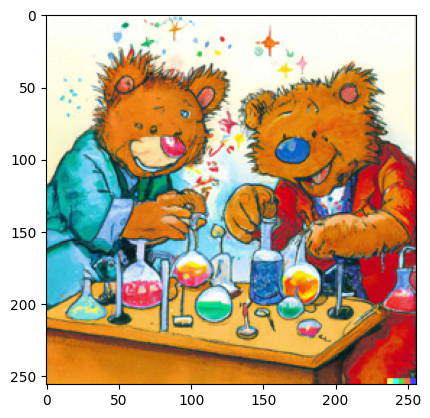

In [60]:
plt.imshow(np.moveaxis(image, 0,-1))

In [61]:
#Simple pre-processing
input_image = torch.from_numpy(image)
input_image = torch.unsqueeze(input_image, dim=0)
input_image.size()

torch.Size([1, 3, 256, 256])

#### 1.1. Implement the architecture

In [62]:
class ImageToText(nn.Module):
    def __init__(self):
        super(ImageToText, self).__init__()
        
        #DEFINE the layers
        #when defining the LSTM be careful with the input size

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding='valid')
        self.conv2a = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding='same')
        self.conv2b = nn.Conv2d(128, 64, kernel_size=1, stride=1, padding='same')
        self.conv2c = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding='same')
        self.conv3 = nn.Conv2d(256, 256, kernel_size=5, stride=4, padding=1)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=5, stride=1, padding='same')
        self.lstm1 = nn.LSTM(256*32*32, hidden_size=128, batch_first=True)
        self.linear1 = nn.Linear(128, 13)


    def forward(self, image):
        # create the pipeline based on the model.png file fomr the current directory
        batch_size = image.size(0)
        print(f'image.shape {image.shape}') # [1, 3, 256, 256]
        
        #SEND the image to the convolutional layers
        features = self.conv1(image)
        print(f'features.shape {features.shape}') # [1, 128, 127, 127]

        l2a = self.conv2a(features)  # [1, 128, 127, 127]
        print(f'l2a.shape {l2a.shape}')
        l2b = self.conv2b(features)  # [1, 64, 127, 127]
        print(f'l2b.shape {l2b.shape}')
        l2c = self.conv2c(features)  # [1, 64, 127, 127]
        print(f'l2c.shape {l2c.shape}')

        #COMBINE the outputs of the convolutional layers
        combined = torch.cat((l2a, l2b, l2c), dim=1)  # [1, 256, 127, 127]
        print(f'combined.shape {combined.shape}')

        #SEND the combined features to the next convolutional layers.
        #Be aware of the ADD operation
        l3 = self.conv3(combined)  # [1, 256, 32, 32]
        print(f'l3.shape {l3.shape}')


        batch_norm = self.bn1(l3)
        print(f'batch_norm.shape {batch_norm.shape}')

        l4 = self.conv4(batch_norm)
        print(f'l4.shape {l4.shape}')

        combined2 = torch.add(l3, l4)
        print(f'combined2.shape {combined2.shape}')

        #RESHAPE the features to the shape (1,batch_size,flattened features) so that it fits the lstm layer
        #Be careful with the LSTM outputs
        reshaped = combined2.reshape(1, batch_size, 256*32*32)
        print(f'reshaped.shape {reshaped.shape}')

        #SEND the LSTM outputs to the final FC layer and sigmoid activation function
        #Rename your last output to "predictions" so it can be returned
        lstm_out, _ = self.lstm1(reshaped)
        print(f'lstm_out.shape {lstm_out.shape}')

        predictions = self.linear1(lstm_out)        
        return predictions #rename your last output as predictions, or change the name here

#### 1.2. Test your implementation
Expected output

torch.Size( [1, 1, 13] )

In [63]:
imagetotext = ImageToText()

output = imagetotext(input_image.float())
print(output.shape)

#summary(imagetotext, (3, 256, 256))


image.shape torch.Size([1, 3, 256, 256])
features.shape torch.Size([1, 128, 127, 127])
l2a.shape torch.Size([1, 128, 127, 127])
l2b.shape torch.Size([1, 64, 127, 127])
l2c.shape torch.Size([1, 64, 127, 127])
combined.shape torch.Size([1, 256, 127, 127])
l3.shape torch.Size([1, 256, 32, 32])
batch_norm.shape torch.Size([1, 256, 32, 32])
l4.shape torch.Size([1, 256, 32, 32])
combined2.shape torch.Size([1, 256, 32, 32])
reshaped.shape torch.Size([1, 1, 262144])
lstm_out.shape torch.Size([1, 1, 128])
torch.Size([1, 1, 13])


In [64]:
tensor = torch.randn(2, 3, 4)
print(tensor)
reshaped_tensor = tensor.reshape(6, 4)
reshaped_tensor

tensor([[[ 1.6622, -0.4173, -1.4858,  0.9302],
         [-1.6412,  0.6843, -1.4030, -1.9493],
         [-1.1825,  0.0906, -0.3646,  0.7757]],

        [[-1.8358, -1.7689,  1.6034,  0.7970],
         [ 0.9187,  1.0722, -0.3092,  0.5335],
         [-0.6756, -0.2103,  0.8789,  0.3708]]])


tensor([[ 1.6622, -0.4173, -1.4858,  0.9302],
        [-1.6412,  0.6843, -1.4030, -1.9493],
        [-1.1825,  0.0906, -0.3646,  0.7757],
        [-1.8358, -1.7689,  1.6034,  0.7970],
        [ 0.9187,  1.0722, -0.3092,  0.5335],
        [-0.6756, -0.2103,  0.8789,  0.3708]])